# USA Names: USA name data from 1937 

This public dataset was created by the Social Security Administration and contains all names from Social Security card applications for births that occurred in the United States after 1879. Note that many people born before 1937 never applied for a Social Security card, so their names are not included in this data. For others who did apply, records may not show the place of birth, and again their names are not included in the data.

All data are from a 100% sample of records on Social Security card applications as of the end of February 2015. To safeguard privacy, the Social Security Administration restricts names to those with at least 5 occurrences. 

#### Libraries

In [2]:
from google.cloud import bigquery
from google.cloud.bigquery import Dataset
from google.cloud import storage

import pandas as pd

#### Set up to query the data

In [3]:
key_path = "C:/IOD/Module_3/spry-semiotics-436014-i6-575a59bcf0cf.json"
client = bigquery.Client.from_service_account_json(key_path)
table_id = "bigquery-public-data.usa_names.usa_1910_current"

#### How big is this dataset?

In [4]:
row_count_query = f"SELECT count(1) as num_rows FROM {table_id}"
query_job = client.query(row_count_query)

for row in query_job:  # API request - fetches results
    # Row values can be accessed by field name or index:
    assert row[0] == row.num_rows == row['num_rows']  #: for debugging bad sql
    print(f"{row.num_rows:,} rows")


6,311,504 rows


# What are the most popular names for girls and for boys in Louisiana?

## Louisiana names 2019-2021
(The data set only goes up to 2021)

## Run the query through the BigQuery API & load the results into a DataFrame
- state = Louisiana
- year >= 2019
- Drop the 'state' column from the results since it is no longer needed


In [5]:
# la_recent_names_query = f"SELECT * FROM {table_id} WHERE state = 'LA' AND year >=2019"
la_recent_names_query = f"SELECT gender, year, name, number FROM {table_id} WHERE state = 'LA' AND year >=2019"
query_job = client.query(la_recent_names_query)
query_results = query_job.result()

# query_job.result() returns a RowIterator object
# .to_dataframe() is a method of the RowIterator
la_recent_names = query_results.to_dataframe()

# How is it that we were able to call .to_dataframe() directly on query_job in the previous lab?

# Recall that you can only use an iterator once!
# To use query_results again it must be generated again

la_recent_names.head(10)

c:\Users\jlefe\.conda\envs\IOD2\lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,gender,year,name,number
0,F,2019,Olivia,255
1,F,2019,Ava,236
2,F,2019,Amelia,208
3,F,2019,Emma,200
4,F,2019,Harper,173
5,F,2019,Charlotte,149
6,F,2019,Sophia,134
7,F,2019,Ella,124
8,F,2019,Avery,118
9,F,2019,Isabella,117


## Top names by year
Get the most popular names for each of the 3 years by using the Pandas method `nlargest`.

This method is only available for a `SeriesGroupBy` object, not `DataFrameGroupBy`s, so we convert the table to a series.
1. Move all of the other columns into the index, resulting in a dataframe with only one column
2. Convert that single-column dataframe to a Series with a multi-index by selecting that column

### Reindex the dataframe

In [6]:
names_reindexed = la_recent_names.set_index(['gender', 'year', 'name'])
print(names_reindexed.head())
print(type(names_reindexed))

                    number
gender year name          
F      2019 Olivia     255
            Ava        236
            Amelia     208
            Emma       200
            Harper     173
<class 'pandas.core.frame.DataFrame'>


### Convert to a Series

In [7]:
names_series = names_reindexed['number']
print(names_series.head(5))
print(type(names_series))

gender  year  name  
F       2019  Olivia    255
              Ava       236
              Amelia    208
              Emma      200
              Harper    173
Name: number, dtype: Int64
<class 'pandas.core.series.Series'>


Group the series to use `nlargest`.

👉🏼 This second `groupby` duplicates the `['gender', 'year']` index, so use `reset_index` (with `drop=True`) to remove the duplicate.

In [8]:
n = 5
largest = names_series.groupby(['gender', 'year']).nlargest(n).reset_index(level=[0, 1], drop=True)
largest

gender  year  name     
F       2019  Olivia       255
              Ava          236
              Amelia       208
              Emma         200
              Harper       173
        2020  Ava          261
              Amelia       225
              Olivia       212
              Emma         190
              Charlotte    153
        2021  Olivia       263
              Ava          218
              Amelia       202
              Charlotte    179
              Emma         165
M       2019  Noah         290
              Elijah       284
              Liam         283
              James        209
              William      191
        2020  Liam         251
              Elijah       237
              Noah         218
              John         182
              William      182
        2021  Liam         261
              Noah         241
              Elijah       220
              James        204
              William      182
Name: number, dtype: Int64

## Show the top names on a parallel coordinates chart

### Reshape for plotting

#### Make each year a column in the dataset

In [9]:
largest = largest.unstack('year').reset_index(level=1)
largest

year,name,2019,2020,2021
gender,,,,
F,Olivia,255,212,263
F,Ava,236,261,218
F,Amelia,208,225,202
F,Emma,200,190,165
F,Harper,173,<NA>,<NA>
F,Charlotte,<NA>,153,179
M,Noah,290,218,241
M,Elijah,284,237,220
M,Liam,283,251,261


#### Separate girls & boys names into different dataframes

In [10]:
girls = largest.loc["F"].reset_index(drop=True) 
girls.columns.rename("", inplace=True) #remove the "year" label on the columns list.  It's confusing to look at.
boys = largest.loc["M"].reset_index(drop=True)
boys.columns.rename("", inplace=True)

print(boys)


      name  2019  2020  2021
0     Noah   290   218   241
1   Elijah   284   237   220
2     Liam   283   251   261
3    James   209  <NA>   204
4  William   191   182   182
5     John  <NA>   182  <NA>


#### Make the plots

In [11]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

Text(0.5, 1.0, "Boys' names")

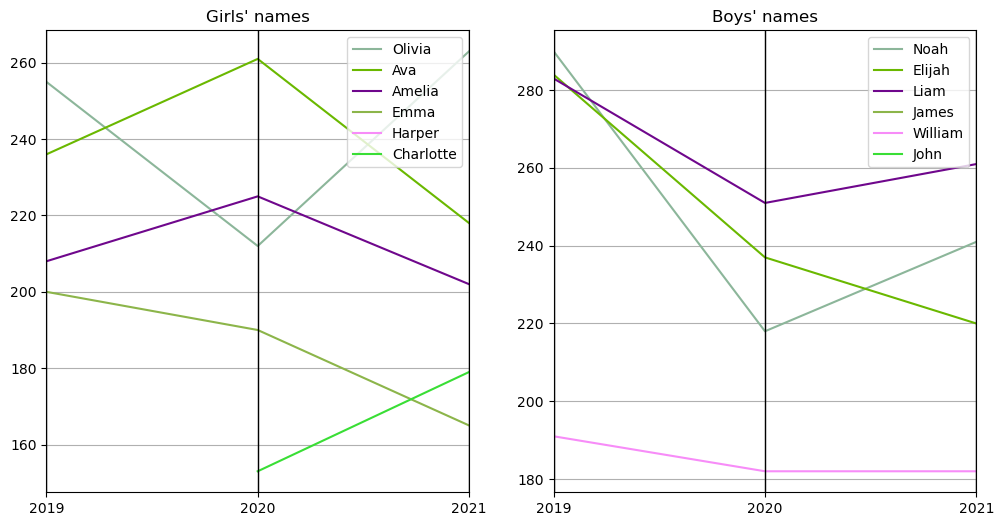

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
parallel_coordinates(girls, "name", ax=ax[0])
ax[0].set_title("Girls' names")
parallel_coordinates(boys, "name", ax=ax[1])
ax[1].set_title("Boys' names")

Can you tell I'm still a novice at `matplotlib`? 🤣

## Unisex names: What were the most popular unisex names in those 3 years?

### Ignore year: Sum all years for gender, name

In [13]:
all_years = la_recent_names.groupby(['gender', 'name'])['number'].sum().reset_index()
all_years.head()


,gender,name,number
0,F,Aaliyah,141
1,F,Abbigail,5
2,F,Abby,23
3,F,Abigail,282
4,F,Abril,5


### Identify unisex names as names that are duplicated in the table -- appearing for both genders

Use the `.duplicated()` method to identify repeated values in `name` column.

Counterintuitively, setting the `keep` aregument to `False` will mark duplicates as `True`. 

In [14]:
all_years['unisex'] = all_years.duplicated(subset='name', keep=False)
unisex = all_years[all_years.unisex].copy() 
unisex.sort_values('name', inplace=True)
unisex.head(10)


,gender,name,number,unisex
56,F,Alex,13,True
1347,M,Alex,93,True
1349,M,Alexis,7,True
59,F,Alexis,41,True
60,F,Ali,5,True
1351,M,Ali,38,True
80,F,Amari,119,True
1357,M,Amari,74,True
92,F,Amiri,8,True
1359,M,Amiri,8,True


### Reshape and total, by different methods than above

#### Reshape with `.pivot()` → Don't have to move columns to the index

In [15]:
unisex_wide = unisex[['gender', 'name', 'number']].pivot(columns='gender', index='name', values='number')
unisex_wide.head()

gender,F,M
name,,
Alex,13,93
Alexis,41,7
Ali,5,38
Amari,119,74
Amiri,8,8


#### Total by adding the columns instead of using `groupby()`

In [16]:
unisex_wide['total'] = unisex_wide['F'] + unisex_wide['M']
unisex_wide.head()


gender,F,M,total
name,,,
Alex,13,93,106
Alexis,41,7,48
Ali,5,38,43
Amari,119,74,193
Amiri,8,8,16


#### Sort the list in order of popularity

In [17]:
unisex_wide.sort_values('total', ascending=False, inplace=True)
unisex_wide.head()


gender,F,M,total
name,,,
Noah,32,749,781
Harper,460,14,474
Avery,348,100,448
Carter,25,415,440
Asher,5,391,396


We can see that some of the names are still heavily assigned to one gender or another.

#### Which names are most evenly divided?

An even split will have each gender proportion close to 0.5 (50%)

In [18]:
unisex_wide['f_pct'] = unisex_wide['F'] / unisex_wide['total']
unisex_wide['Δ from 0.5'] = (unisex_wide['f_pct'] - 0.5).abs()
unisex_wide.head()

gender,F,M,total,f_pct,Δ from 0.5
name,,,,,
Noah,32,749,781,0.040973,0.459027
Harper,460,14,474,0.970464,0.470464
Avery,348,100,448,0.776786,0.276786
Carter,25,415,440,0.056818,0.443182
Asher,5,391,396,0.012626,0.487374


In [19]:
unisex_wide.sort_values('Δ from 0.5', inplace=True)
unisex_wide

gender,F,M,total,f_pct,Δ from 0.5
name,,,,,
Finnley,5,5,10,0.5,0.0
Kasey,5,5,10,0.5,0.0
Whitney,5,5,10,0.5,0.0
Amiri,8,8,16,0.5,0.0
Tatum,55,57,112,0.491071,0.008929
...,...,...,...,...,...
Christian,6,271,277,0.021661,0.478339
Jayden,6,298,304,0.019737,0.480263
Lincoln,5,258,263,0.019011,0.480989


Some of the even split names are infrequent (N = 10)

#### Which names are both popular and close to evenly split?

##### How to define "popular" in terms of the data?

In [20]:
unisex_wide['total'].describe()

count         156.0
mean          127.0
std      111.201938
min            10.0
25%           51.75
50%            96.5
75%           170.0
max           781.0
Name: total, dtype: Float64

[  9.229  87.1   164.2   241.3   318.4   395.5   472.6   549.7   626.8
 703.9   781.   ]


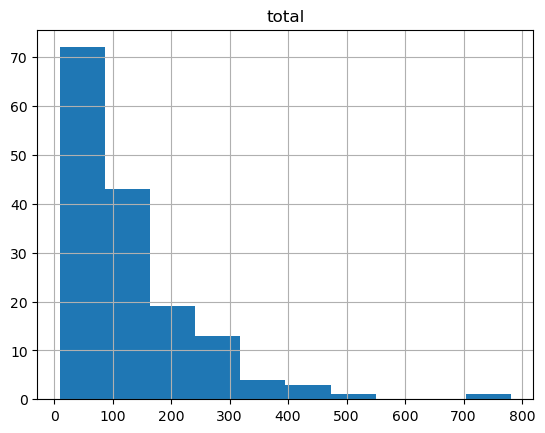

In [21]:

unisex_wide.hist('total', bins=10)

# Use pd.cut() to determine bin values.
# first sort the data so that the list returned from .cut() will be in the right order  
unisex_wide.sort_values('total') 
bins = pd.cut(unisex_wide['total'], bins=10, retbins=True)

print(bins[1])

What is this bin between 700 nand 800?

In [22]:
unisex_wide[unisex_wide.total > 700]

gender,F,M,total,f_pct,Δ from 0.5
name,,,,,
Noah,32,749,781,0.040973,0.459027


⬆️ "Noah" assigned 781 times.  Noah, you're pulling my average out of whack :(

Define 'popular' as top 50% of total assignments

In [23]:
median = unisex_wide['total'].quantile() # ---> 96.5
unisex_wide['popular'] = unisex_wide.total > median
unisex_wide.sample(7)

gender,F,M,total,f_pct,Δ from 0.5,popular
name,,,,,,
Cohen,5,163,168,0.029762,0.470238,True
Jayden,6,298,304,0.019737,0.480263,True
Alex,13,93,106,0.122642,0.377358,True
Ivory,29,6,35,0.828571,0.328571,False
Jessie,23,18,41,0.560976,0.060976,False
Tatum,55,57,112,0.491071,0.008929,True
Hollis,11,20,31,0.354839,0.145161,False


##### How to define "evenly split" in terms of the data

Explore the evenness scores

array([[<Axes: title={'center': 'Δ from 0.5'}>]], dtype=object)

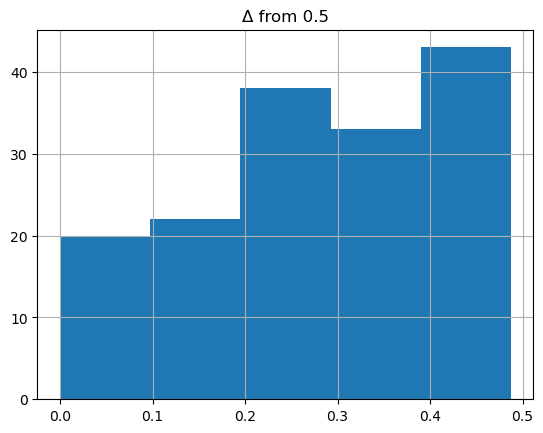

In [24]:
unisex_wide.hist('Δ from 0.5', bins = 5)

Define 'evenly split' as in 0.5 ± 0.05 (45% - 55%)

In [27]:
unisex_wide['even'] = unisex_wide['Δ from 0.5'] <= 0.05 
unisex_wide.sample(7)

gender,F,M,total,f_pct,Δ from 0.5,popular,even
name,,,,,,,
Riley,242,81,323,0.749226,0.249226,True,False
Sawyer,78,207,285,0.273684,0.226316,True,False
Kacey,5,20,25,0.2,0.3,False,False
Ivory,29,6,35,0.828571,0.328571,False,False
Finnley,5,5,10,0.5,0.0,False,True
Karter,38,287,325,0.116923,0.383077,True,False
Skyler,28,7,35,0.8,0.3,False,False


##### Results: Popular and evenly applied unisex names

In [26]:
unisex_wide[unisex_wide.popular & unisex_wide.even]

gender,F,M,total,f_pct,Δ from 0.5,popular,even
name,,,,,,,
Tatum,55,57,112,0.491071,0.008929,True,True
Emerson,65,57,122,0.532787,0.032787,True,True
Dakota,84,70,154,0.545455,0.045455,True,True
